# Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbMetricsLogger
%matplotlib inline

wandb.login()

2023-03-10 02:07:58.761321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 02:07:58.899937: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 02:07:59.514337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/signal/anaconda3/lib/:/home/signal/anaconda3/lib/
2023-03-10 02:07:59.514434: W 

True

# Dataset Loader and Preparation

In [3]:
# Import image 

# Import freq domain
def load_freq_img_train_dataset():
    
    annotations = pd.read_csv('annotations.csv') # <= Set Your Annotation Path Here!!!

    X_train=[]
    y_train=[]
    for i in range(len(annotations)):
        
        filename = annotations.iloc[i]['id'] # get filename from annotations
        label = annotations.iloc[i]['class'] # get class from annotations

        img = cv2.imread('freq_img_gray/train/'+ filename +'.jpg') # import image <= Set Your Image Path Here!!!
        
        img = cv2.resize(img, (256, 256)) ## Configure Your Image Size Here!!!
        
        X_train.append(img)
        y_train.append(label)

    return X_train, y_train

# Import freq domain
def load_time_img_train_dataset():
    
    annotations = pd.read_csv('annotations.csv') # <= Set Your Annotation Path Here!!!

    X_train=[]
    y_train=[]
    for i in range(len(annotations)):
        
        filename = annotations.iloc[i]['id'] # get filename from annotations
        label = annotations.iloc[i]['class'] # get class from annotations

        img = cv2.imread('time_img_gray_bgsup/train/'+ filename +'.jpg') # import image <= Set Your Image Path Here!!!
        
        img = cv2.resize(img, (256, 256)) ## Configure Your Image Size Here!!!
        
        X_train.append(img)
        y_train.append(label)

    return X_train, y_train

In [4]:
X_time_train, y_train = load_time_img_train_dataset()

X_freq_train, y_train = load_freq_img_train_dataset()

X_train = np.array([ (i,j) for i,j in zip(X_time_train, X_freq_train) ])

# Change to List to Array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Train Val Split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=58)

print('Before SMOTE')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print()

# smote
from imblearn.over_sampling import SMOTE

train_size = X_train.shape[0]
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train.reshape(train_size,-1),y_train)

train_size = X_train.shape[0]
X_train = X_train.reshape(train_size, 2, 256, 256, 3)

print('After SMOTE')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print()

# split back into 2 inputs: time and freq
X_time_train = np.array([i[0] for i in X_train])
X_freq_train = np.array([i[1] for i in X_train])
X_time_val = np.array([i[0] for i in X_val])
X_freq_val = np.array([i[1] for i in X_val])

print('Split into 2 inputs')
print(X_time_train.shape)
print(X_freq_train.shape)
print(X_time_val.shape)
print(X_freq_val.shape)

Before SMOTE
(516, 2, 256, 256, 3)
(516,)
(130, 2, 256, 256, 3)
(130,)

After SMOTE
(658, 2, 256, 256, 3)
(658,)
(130, 2, 256, 256, 3)
(130,)

Split into 2 inputs
(658, 256, 256, 3)
(658, 256, 256, 3)
(130, 256, 256, 3)
(130, 256, 256, 3)


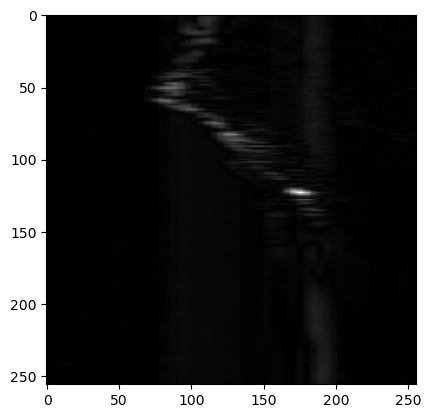

In [5]:
plt.imshow(X_time_val[0])

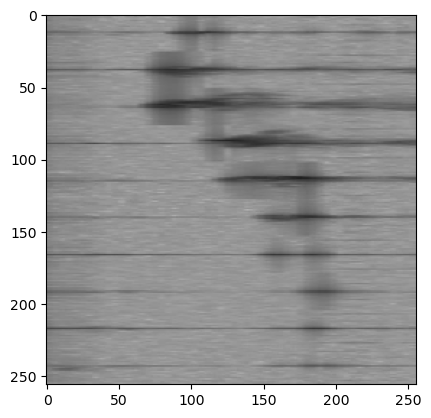

In [6]:
plt.imshow(X_freq_val[0])

In [7]:
# One Hot Encoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1,1)).toarray()

# Model Setting
- https://keras.io/api/applications/ (Base Model with Pretrained)

In [1]:
# Model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, GlobalMaxPooling2D, Dropout, Input, concatenate

# Base Model (Can configure)
from tensorflow.keras.applications import EfficientNetV2S

# Optimizers (Can configure)
from tensorflow.keras.optimizers import Adam

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2023-03-10 12:20:47.867947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 12:20:47.976872: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 12:20:48.591675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/signal/anaconda3/lib/:/home/signal/anaconda3/lib/
2023-03-10 12:20:48.591758: W 

In [2]:
def win_layer(basemodel, mode):
    
    if mode == "A":
        for layer in basemodel.layers:
            if 'block6' in layer.name:
                layer.trainable = True
            elif 'block5' in layer.name:
                layer.trainable = True
            elif 'top' in layer.name:
                layer.trainable = True
            else:
                layer.trainable = False
                
    elif mode == "B":
        for layer in basemodel.layers:
            if 'block6' in layer.name:
                layer.trainable = True
            elif 'block5' in layer.name:
                layer.trainable = True
            elif 'top' in layer.name:
                layer.trainable = True
            else:
                layer.trainable = False

In [3]:
def create_super_model():
    
    # define two sets of inputs
    inputA = Input(shape=(256, 256, 3), name='Range-Time Data')
    inputB = Input(shape=(256, 256, 3), name='Range-Freq Data')
    
    # first model
    basemodelA = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    basemodelA._name = 'Time_EfficientNetV2S' #change model name
    win_layer(basemodelA,mode="A")
    
    a = basemodelA(inputA)
    
#     a = GlobalMaxPooling2D(name ='gapA')(a)
#     a = Dense(128, activation='relu', name ='fc1A')(a)
#     a = Dropout(0.4, name='drop_outA')(a)
#     # a = Dense(7, activation="softmax", name ='fc2A')(a)
    x = Model(inputs=inputA, outputs=a)
      
    # second model
    basemodelB = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    basemodelB._name = 'Freq_EfficientNetV2S' #change model name
    win_layer(basemodelB,mode="B")
    
    b = basemodelB(inputB)
    # b = GlobalMaxPooling2D(name ='gapB')(b)
    # b = Dense(128, activation='relu', name ='fc1B')(b)
    # b = Dropout(0.4, name='drop_outB')(b)
    # # b = Dense(7, activation="softmax", name ='fc2B')(b)
    y = Model(inputs=inputB, outputs=b)
    
    # concatenated model
    combined = concatenate([x.output, y.output])
    
    z = GlobalMaxPooling2D(name ='GlobalMaxPooling2D')(combined)
    z = Dense(128, activation='relu', name ='Dense_1')(z)
    z = Dropout(0.4, name='Dropout')(z)
    # b = Dense(7, activation="softmax", name ='fc2B')(b)
    z = Dense(7, activation="softmax", name='Output')(z)

    # combine model
    model = Model(inputs=[x.input, y.input], outputs=z)
    
    return model

In [4]:
model = create_super_model()
model.summary()

2023-03-10 12:20:49.575816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 12:20:49.581704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 12:20:49.581980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 12:20:49.582440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Range-Time Data (InputLayer)   [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Range-Freq Data (InputLayer)   [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Time_EfficientNetV2S (Function  (None, 8, 8, 1280)  20331360    ['Range-Time Data[0][0]']        
 al)                                                                                        

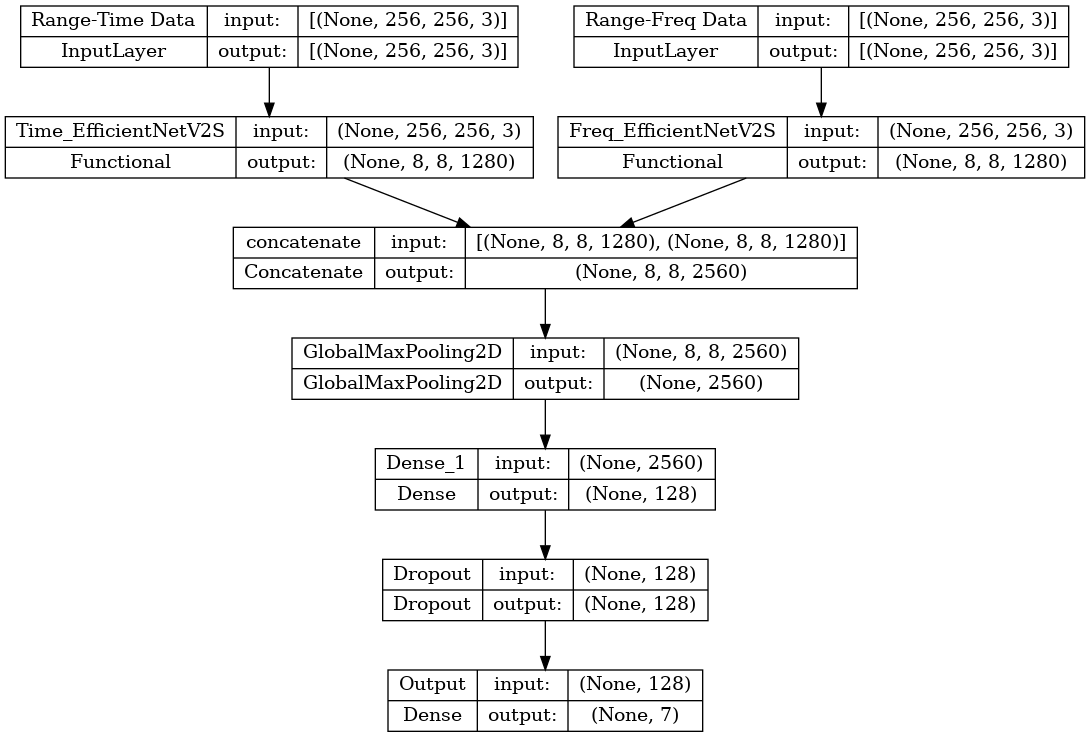

In [5]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [13]:
# Training Parameters Setting
run_name = f'EfficientNetV2S-timeXfreq-02'
result_path = f'img-results/{run_name}'
if not os.path.exists(result_path):
    os.mkdir(result_path)

config = {
    'architecture': 'EfficientNetV2S',
    'lr': 1e-3,
    'early_stop_patience' : 15,
    'epochs': 200,
    'batch_size': 16,
    # 'best_model_path': f'img-results/{run_name}/best_model.h5'
    'best_model_path': f'img-results/{run_name}/best_model.tf'
}

In [14]:
# Setting Optimizer, Loss , and Metric
model.compile(optimizer=Adam(learning_rate= config['lr']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Setting Callbacks

checkpoint = ModelCheckpoint(config['best_model_path'],
                             verbose=1,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=config['early_stop_patience'],
                              verbose=0,
                              mode='min')

# Train

In [16]:
# Wandb
wandb.init(project = f"{run_name}", config=config)

# Train
history = model.fit([X_time_train, X_freq_train],
                    y_train,
                    batch_size = config['batch_size'],
                    epochs = config['epochs'],
                    validation_data=([X_time_val, X_freq_val], y_val),
                    callbacks=[checkpoint, earlyStopping, WandbMetricsLogger()])

Epoch 1/200


2023-03-10 02:11:46.969842: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/Basemodel_A/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-10 02:11:55.556691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-10 02:11:56.094789: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-10 02:11:57.312374: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9a24012f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 02:11:57.312413: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-10 02:11:57.317173: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, 

42/42 [==============================] - ETA: 0s - loss: 2.7024 - accuracy: 0.3693
Epoch 1: val_loss improved from inf to 1.18085, saving model to img-results/EfficientNetV2S-timeXfreq-02/best_model.tf


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


42/42 [==============================] - 323s 5s/step - loss: 2.7024 - accuracy: 0.3693 - val_loss: 1.1809 - val_accuracy: 0.6077
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 1.1168 - accuracy: 0.5775
Epoch 2: val_loss improved from 1.18085 to 0.79864, saving model to img-results/EfficientNetV2S-timeXfreq-02/best_model.tf


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


42/42 [==============================] - 213s 5s/step - loss: 1.1168 - accuracy: 0.5775 - val_loss: 0.7986 - val_accuracy: 0.7615
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 0.9513 - accuracy: 0.6429
Epoch 3: val_loss did not improve from 0.79864
42/42 [==============================] - 17s 404ms/step - loss: 0.9513 - accuracy: 0.6429 - val_loss: 0.9279 - val_accuracy: 0.7231
Epoch 4/200
42/42 [==============================] - ETA: 0s - loss: 0.8577 - accuracy: 0.6915
Epoch 4: val_loss did not improve from 0.79864
42/42 [==============================] - 17s 408ms/step - loss: 0.8577 - accuracy: 0.6915 - val_loss: 0.8674 - val_accuracy: 0.6846
Epoch 5/200
42/42 [==============================] - ETA: 0s - loss: 0.7999 - accuracy: 0.7416
Epoch 5: val_loss did not improve from 0.79864
42/42 [==============================] - 17s 410ms/step - loss: 0.7999 - accuracy: 0.7416 - val_loss: 0.8393 - val_accuracy: 0.7231
Epoch 6/200
42/42 [=============================

INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


42/42 [==============================] - 215s 5s/step - loss: 0.7434 - accuracy: 0.7432 - val_loss: 0.7659 - val_accuracy: 0.7615
Epoch 7/200
42/42 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.7599
Epoch 7: val_loss did not improve from 0.76589
42/42 [==============================] - 17s 404ms/step - loss: 0.7184 - accuracy: 0.7599 - val_loss: 1.1670 - val_accuracy: 0.7077
Epoch 8/200
42/42 [==============================] - ETA: 0s - loss: 0.8195 - accuracy: 0.7310
Epoch 8: val_loss did not improve from 0.76589
42/42 [==============================] - 17s 407ms/step - loss: 0.8195 - accuracy: 0.7310 - val_loss: 0.8168 - val_accuracy: 0.7538
Epoch 9/200
42/42 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8389
Epoch 9: val_loss did not improve from 0.76589
42/42 [==============================] - 17s 410ms/step - loss: 0.4817 - accuracy: 0.8389 - val_loss: 1.0207 - val_accuracy: 0.7231
Epoch 10/200
42/42 [============================

INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


42/42 [==============================] - 218s 5s/step - loss: 0.6552 - accuracy: 0.8146 - val_loss: 0.6671 - val_accuracy: 0.8077
Epoch 13/200
42/42 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.8739
Epoch 13: val_loss improved from 0.66711 to 0.47701, saving model to img-results/EfficientNetV2S-timeXfreq-02/best_model.tf


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


INFO:tensorflow:Assets written to: img-results/EfficientNetV2S-timeXfreq-02/best_model.tf/assets


42/42 [==============================] - 216s 5s/step - loss: 0.4322 - accuracy: 0.8739 - val_loss: 0.4770 - val_accuracy: 0.8538
Epoch 14/200
42/42 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8754
Epoch 14: val_loss did not improve from 0.47701
42/42 [==============================] - 17s 405ms/step - loss: 0.4144 - accuracy: 0.8754 - val_loss: 0.7599 - val_accuracy: 0.8231
Epoch 15/200
42/42 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.8556
Epoch 15: val_loss did not improve from 0.47701
42/42 [==============================] - 17s 408ms/step - loss: 0.4184 - accuracy: 0.8556 - val_loss: 1.1821 - val_accuracy: 0.6923
Epoch 16/200
42/42 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8921
Epoch 16: val_loss did not improve from 0.47701
42/42 [==============================] - 17s 411ms/step - loss: 0.3521 - accuracy: 0.8921 - val_loss: 0.9397 - val_accuracy: 0.7769
Epoch 17/200
42/42 [======================

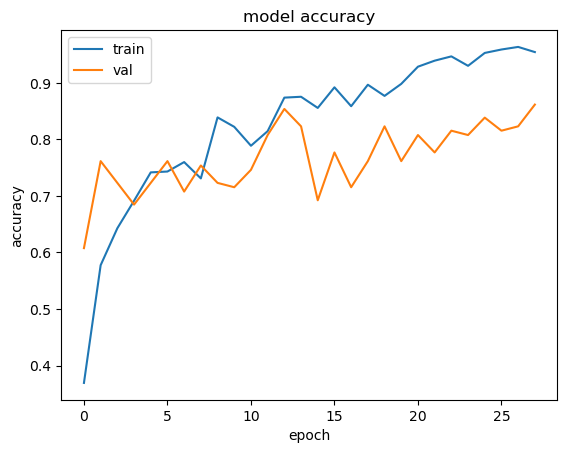

<Figure size 640x480 with 0 Axes>

In [24]:
# Visualize Training Graph
# Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig(f'img-results/{run_name}/accuracy.png')

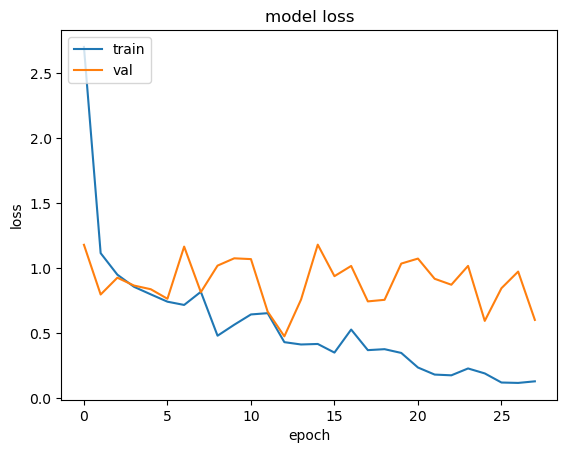

<Figure size 640x480 with 0 Axes>

In [25]:
# Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig(f'img-results/{run_name}/loss.png')

# Eval

In [19]:
from keras.models import load_model # For loading Model

5/5 [==============================] - 7s 249ms/step
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.95      0.95      0.95        20
           2       1.00      0.42      0.59        12
           3       0.93      0.82      0.87        17
           4       0.92      0.85      0.88        26
           5       0.94      0.84      0.89        19
           6       0.81      0.96      0.88        27

    accuracy                           0.85       130
   macro avg       0.87      0.83      0.82       130
weighted avg       0.89      0.85      0.85       130

[[ 9  0  0  0  0  0  0]
 [ 0 19  0  1  0  0  0]
 [ 7  0  5  0  0  0  0]
 [ 0  1  0 14  0  0  2]
 [ 0  0  0  0 22  0  4]
 [ 1  0  0  0  2 16  0]
 [ 0  0  0  0  0  1 26]]


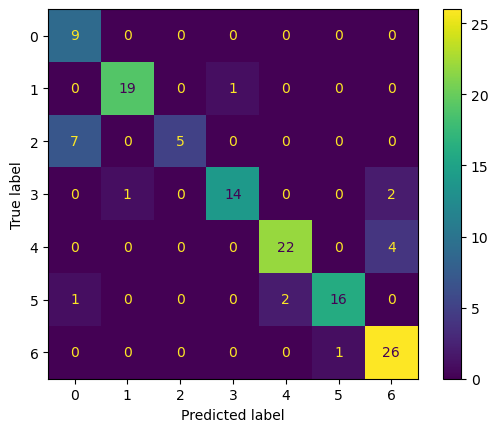

In [21]:
# Load Best weight into Model
best_weight_path = f'img-results/{run_name}/best_model.tf' # <= Set Your Best Weight Path Here!!!
model = load_model(best_weight_path)

val_pred = model.predict([X_time_val, X_freq_val])

val_pred = np.argmax(val_pred, axis = 1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true=np.argmax(y_val, axis = 1), y_pred=val_pred))

cm = confusion_matrix(y_true=np.argmax(y_val, axis = 1), y_pred=val_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Test

In [35]:
# Load Sample Submission File 

df = pd.read_csv('sample_submission.csv')
df.head()

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,6.0
1,84e55af1-ae63-4b06-b650-1136d38b691e,4.0
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2.0
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,NaN
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,NaN


In [43]:
time_test = []
for i in range(len(df)):
    filename = 'time_img_gray_bgsup/test/'+df.iloc[i]['id']+'.jpg' # <= Set Your Image Path Here!!!
    img = cv2.imread(filename) # import image 
    img = cv2.resize(img, (256,256))# <= Set Your Image Size Here!!!
    time_test.append(img)

freq_test = []
for i in range(len(df)):
    filename = 'freq_img_gray/test/'+df.iloc[i]['id']+'.jpg' # <= Set Your Image Path Here!!!
    img = cv2.imread(filename) # import image
    img = cv2.resize(img, (256,256))# <= Set Your Image Size Here!!!
    freq_test.append(img)

In [44]:
time_test = np.array(time_test) # Convert to array
freq_test = np.array(freq_test)

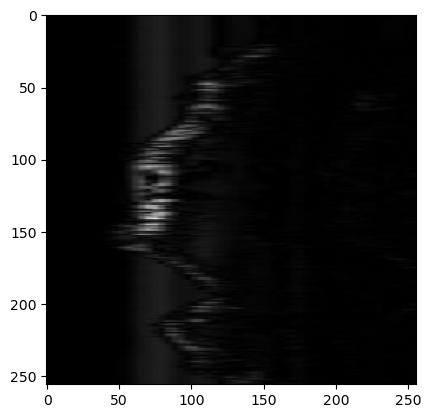

In [45]:
plt.imshow((time_test[10]))

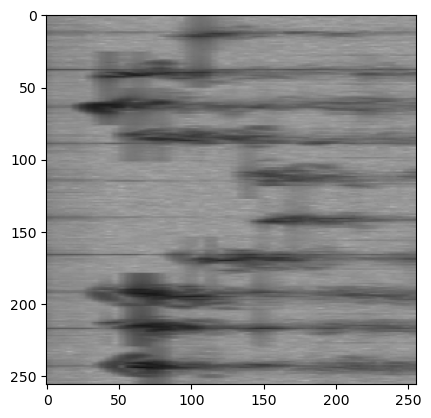

In [46]:
plt.imshow((freq_test[0]))

In [47]:
time_test = np.array(time_test) # Convert to array
freq_test = np.array(freq_test)

# Load Best weight into Model
# best_weight_path = 'img-results/EfficientNetV2S-freq-gray/best_model.h5' # <= Set Your Best Weight Path Here!!!
# model = load_model(best_weight_path)

# Prediction
pred = model.predict([time_test, freq_test])

# Get Prediction result
result = np.argmax(pred, axis=1)

6/6 [==============================] - 2s 256ms/step


In [48]:
# Check Your Result
df['class'] = result
df.head()

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,3
1,84e55af1-ae63-4b06-b650-1136d38b691e,5
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,0
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0


In [49]:
df

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,3
1,84e55af1-ae63-4b06-b650-1136d38b691e,5
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,0
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0
...,...,...
159,5fce955d-1068-40b3-afc3-111f8c22c9f9,3
160,f3a000be-07c9-44ad-8ff0-b89a9a1070dd,4
161,84d3963b-cfed-450c-88ab-ca853273d15c,1
162,7b36184c-5541-44d9-9200-8057bd3cf4ef,6


In [50]:
run_name

'EfficientNetV2S-timeXfreq-02'

In [51]:
# Save Your Result

path_to_save = f'img-results/{run_name}/{run_name}_submission.csv' # <= Set Your Save Path Here!!!
df.to_csv(path_to_save,index=False)

print("= Good Luck ="*20)

= Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck =
